# Introduction

# Importing Libraries


In [1]:
import pandas as pd
import numpy as np

! python -m spacy download en_core_web_md
import spacy
spacy.prefer_gpu()

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
nlp = spacy.load('en_core_web_md')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def show_confusion_matrix(y_train_true,y_val_true,y_test_true,y_pred_train,y_pred_val,y_pred_test):
    true = [y_train_true,y_val_true,y_test_true]
    pred = [y_pred_train,y_pred_val,y_pred_test]
    for i in range(3):
        plot_confusion_matrix(confusion_matrix(true[i], pred[i]),target_names = ['N-Recommended','Recommended'],
                              title=print('F1_score de: {}%'.format(
                                  round(f1_score(true[i],pred[i])*100,4))),cmap=None,normalize=True)

In [0]:
def flatten(lst):
    new_lst = []
    flatten_helper(lst, new_lst)
    return new_lst
 
def flatten_helper(lst, new_lst):
    for element in lst:
        if isinstance(element, list):
            flatten_helper(element, new_lst)
        else:
            new_lst.append(element)

In [0]:
def RemoveSmallWords(Series):
    t = Series.str.split(expand=True).stack()
    return t.loc[t.str.len() >= 4].groupby(level=0).apply(' '.join)

In [0]:
def TextPreProcessing (df,text_column,nlp_spacy):
  df.loc[df[text_column].isna(),text_column] = '-EMPTY-'
  # Creating Corpus with Spacy pipe.
  corpus = list(nlp_spacy.pipe(df[text_column]))
  a_lemmas = []
  for i in range(len(corpus)):
    try:
      #creating name entity recognition list for the especific corpus
      ents = [ent.text.split() for ent in corpus[i].ents]
      ents = flatten(ents)    
      # Tokenization with lemmatizer
      lemmas = [token.lemma_ for token in corpus[i]]
      # Removing non-alphabetic characters
      a_lemmas.append(pd.Series([lemma for lemma in lemmas if (lemma.isalpha() and nlp.vocab[lemma].is_stop==False)])) 
      # Removing ents
      a_lemmas[i] = a_lemmas[i][~a_lemmas[i].isin(pd.Series(ents))]
      # Removing small words
      a_lemmas[i] = RemoveSmallWords(a_lemmas[i])
      a_lemmas[i].reset_index(inplace = True, drop = True)
    except:
      a_lemmas[i] = '-EMPTY-'
    a_lemmas[i] = ' '.join(a_lemmas[i])
  df[text_column] = a_lemmas
  return df

In [0]:
def percent_out(qtd_0,qtd_1,coef):
  return 1 - ((coef*qtd_0)/qtd_1) 

In [0]:
def dataSplit(df,train_percent,val_percent):
  train_limit = int(round((df.shape[0])*train_percent,0))
  val_limit = int(round((df.shape[0])*(train_percent+val_percent),0))
  
  df_train = df[:train_limit]
  df_val = df[train_limit:val_limit]
  df_test = df[val_limit:]

  return df_train,df_val,df_test

# Importing Data

In [11]:
df = pd.read_csv('/content/drive/My Drive/ML Projects/Womens Clothing E-Commerce/Womens Clothing E-Commerce Reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


# Dealing with the unbalanced target

The target Recommended IND has more class 1 (recommended) than 0 (not recommended). The imbalance is a little bigger than 4.62 times.

When the dataset has a unbalanced target with one class bigger than 3 times the other, the machine learning algorithms tend have poor performance.

I'll balance the target with differents proportiond, trying to show the performance variations of some machine learning algorithms.

============================Unbalance Rate:1.0===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 1.0, 'f1_score_train': 0.863843192159608, 'f1_score_val': 0.8312655086848635, 'f1_score_test': 0.8723464477780922}
F1_score de: 86.3843%


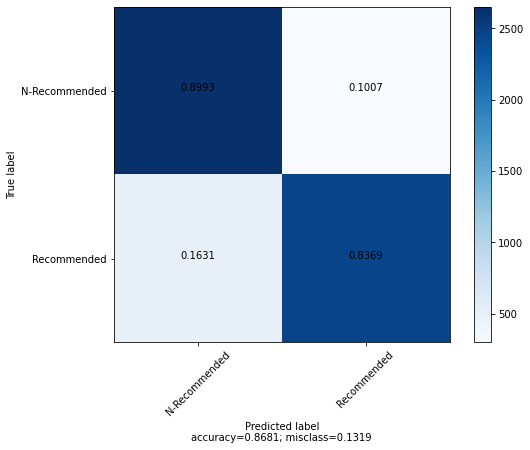

F1_score de: 83.1266%


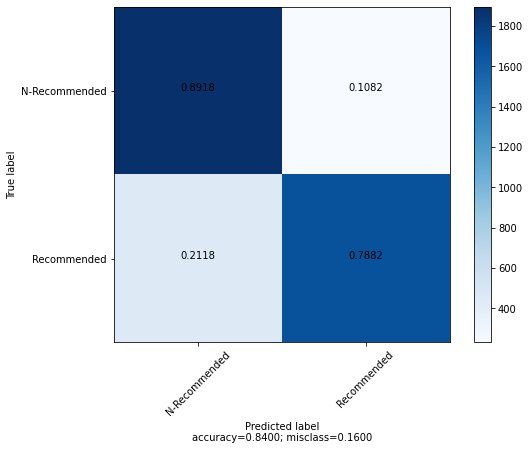

F1_score de: 87.2346%


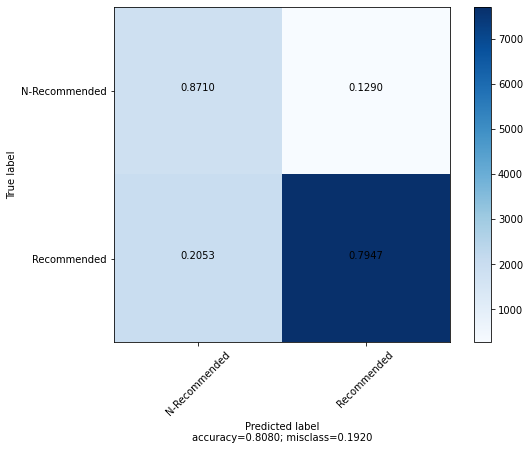



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 1.0, 'f1_score_train': 0.9722410291130671, 'f1_score_val': 0.9073243647234678, 'f1_score_test': 0.9016738720762665}
F1_score de: 97.2241%


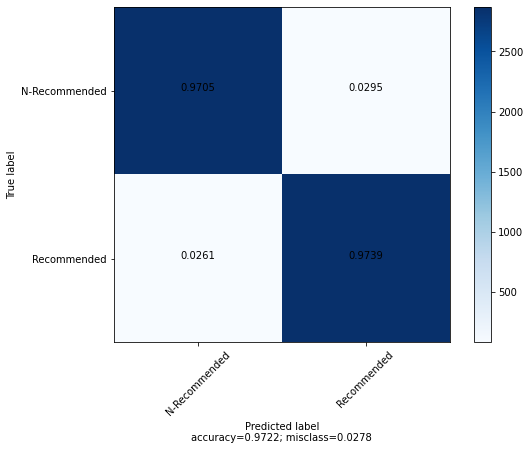

F1_score de: 90.7324%


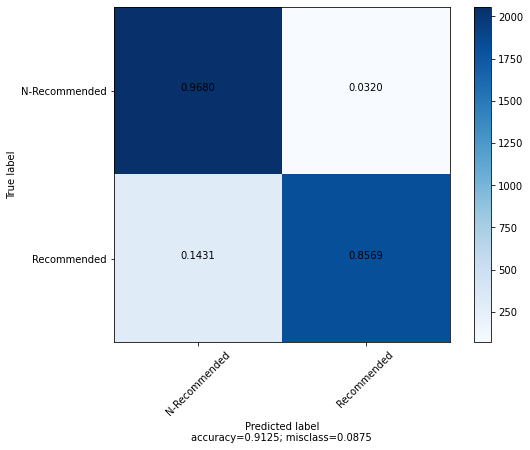

F1_score de: 90.1674%


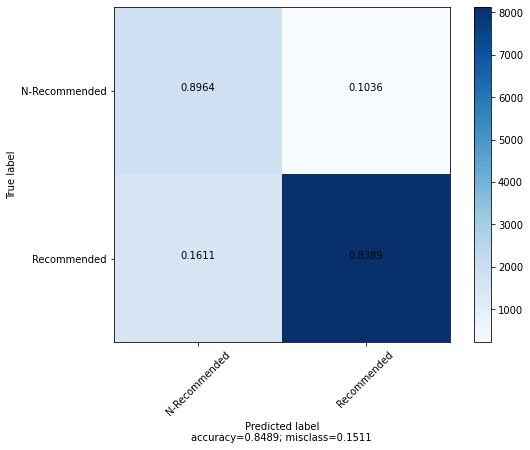



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

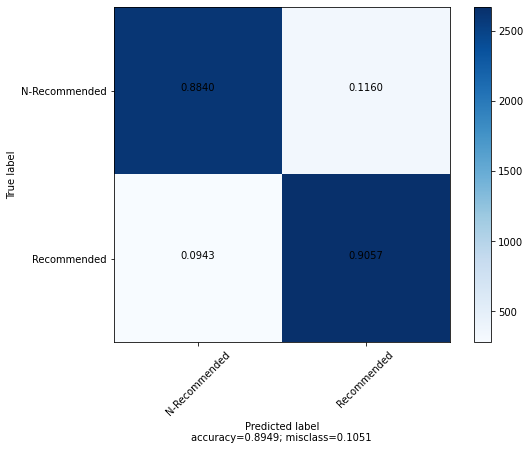

F1_score de: 85.2792%


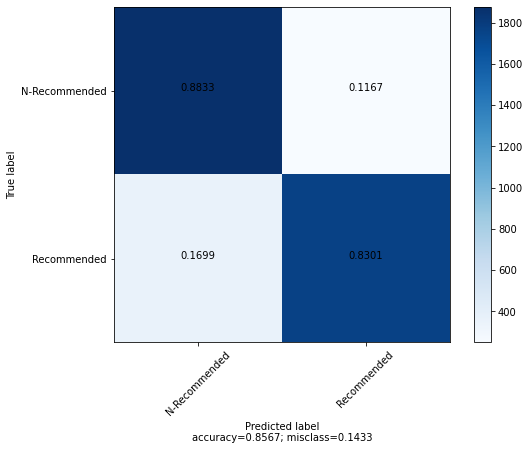

F1_score de: 88.6394%


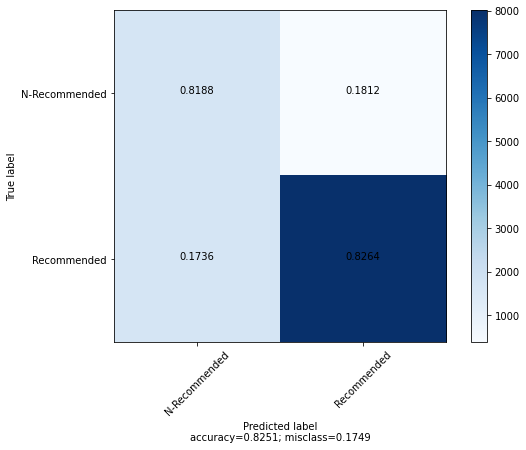



============================Unbalance Rate:1.499830451000339===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 1.499830451000339, 'f1_score_train': 0.8824499896885957, 'f1_score_val': 0.8716986578149805, 'f1_score_test': 0.9356630643369357}
F1_score de: 88.245%


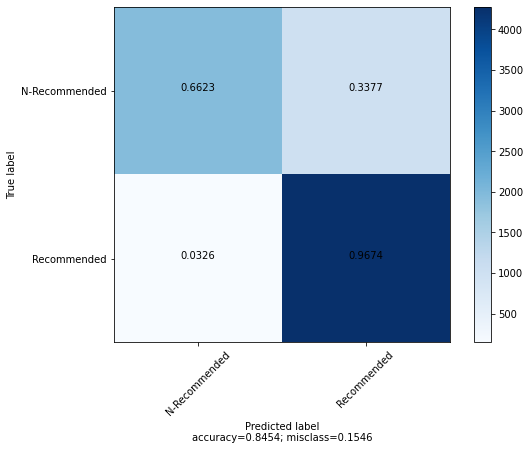

F1_score de: 87.1699%


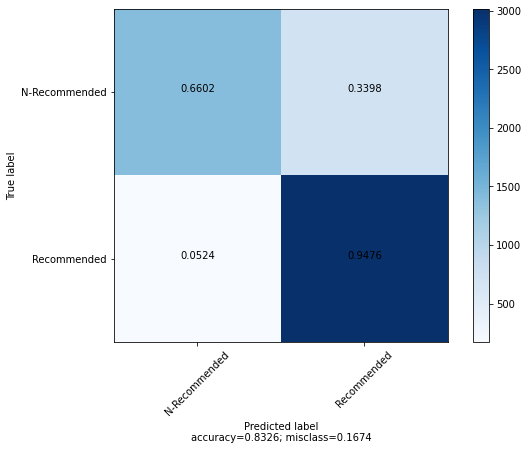

F1_score de: 93.5663%


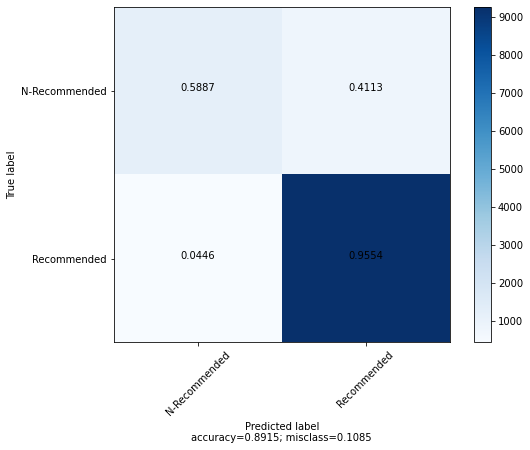



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 1.499830451000339, 'f1_score_train': 0.9739618406285072, 'f1_score_val': 0.9395109395109396, 'f1_score_test': 0.9314048707859194}
F1_score de: 97.3962%


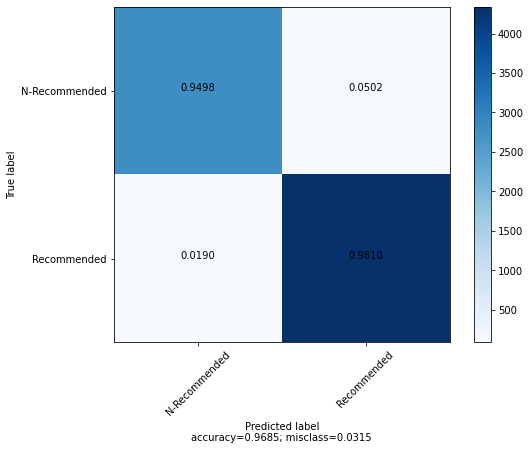

F1_score de: 93.9511%


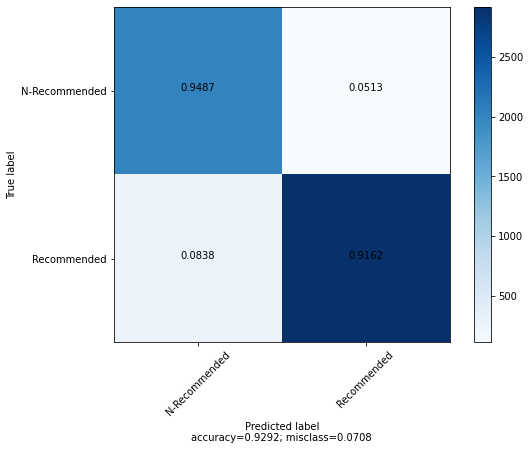

F1_score de: 93.1405%


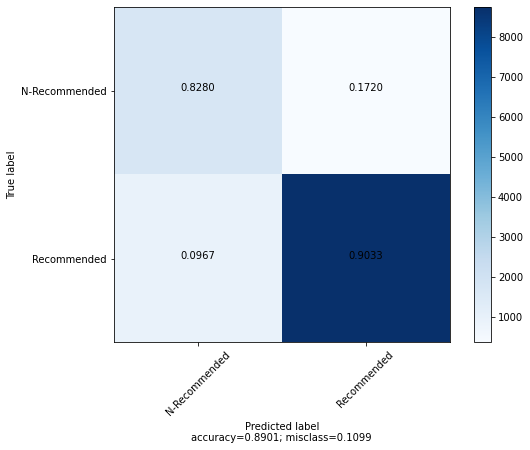



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

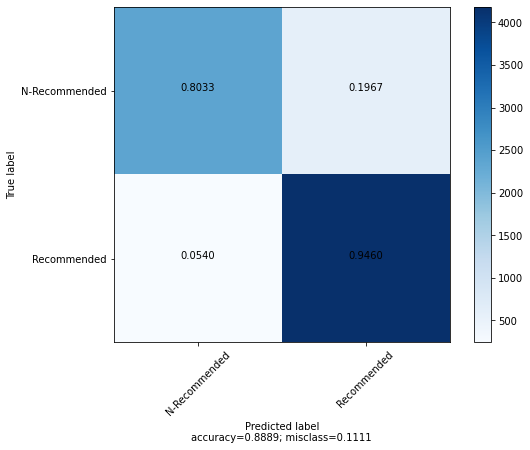

F1_score de: 88.6142%


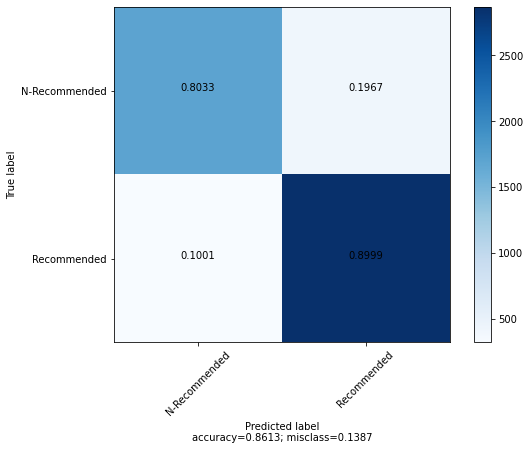

F1_score de: 91.9204%


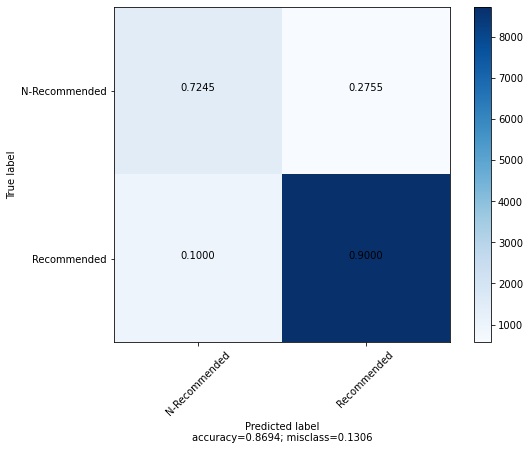



============================Unbalance Rate:1.9996609020006781===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 1.9996609020006781, 'f1_score_train': 0.8770343580470162, 'f1_score_val': 0.8756156344964896, 'f1_score_test': 0.9324013881421379}
F1_score de: 87.7034%


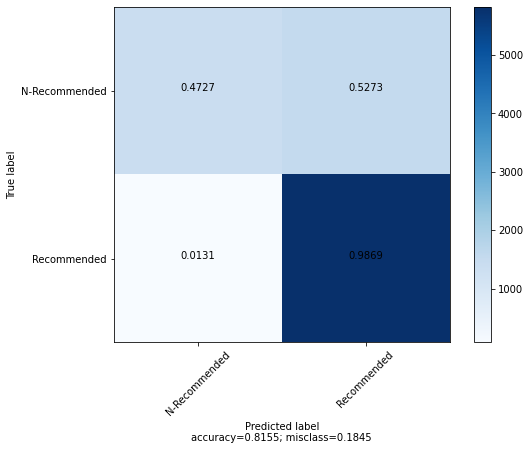

F1_score de: 87.5616%


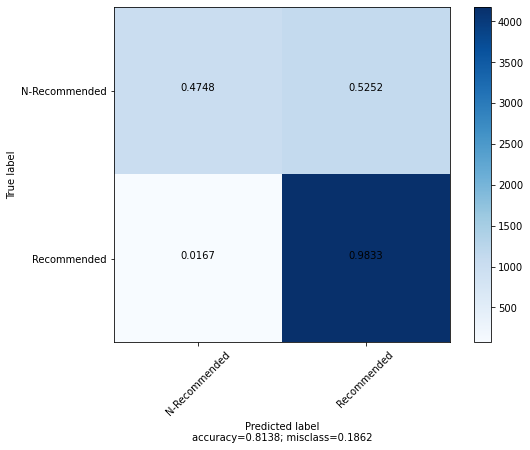

F1_score de: 93.2401%


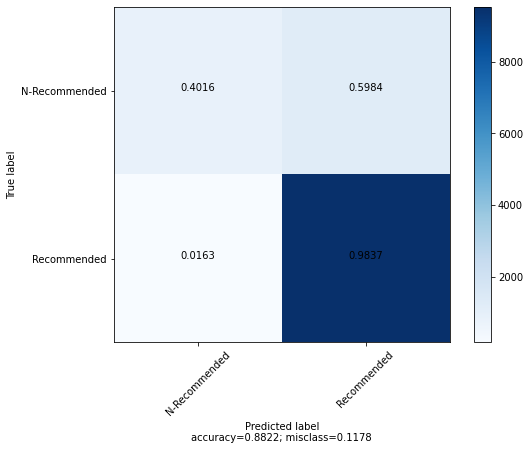



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 1.9996609020006781, 'f1_score_train': 0.9772593773600738, 'f1_score_val': 0.9569241723033107, 'f1_score_test': 0.9417283435838633}
F1_score de: 97.7259%


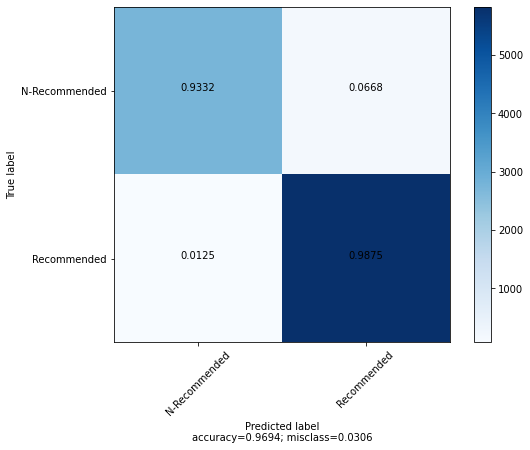

F1_score de: 95.6924%


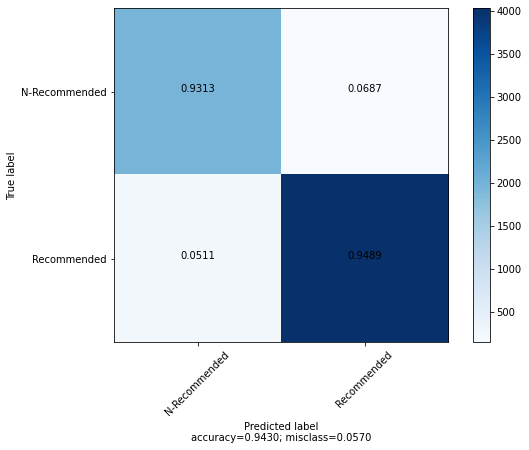

F1_score de: 94.1728%


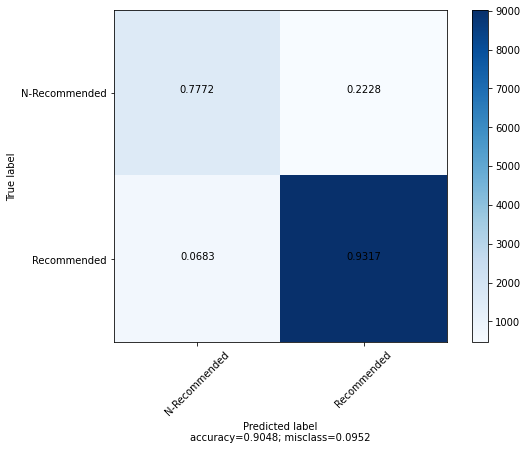



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

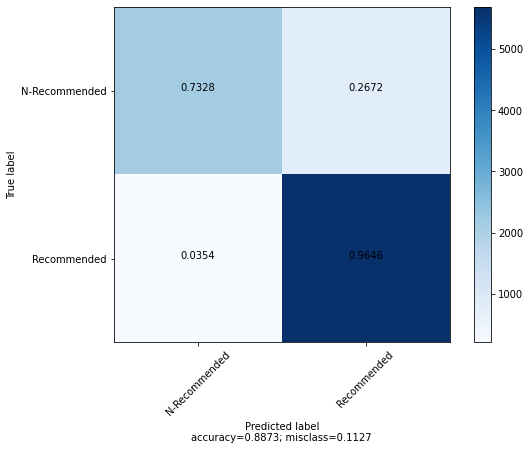

F1_score de: 90.3387%


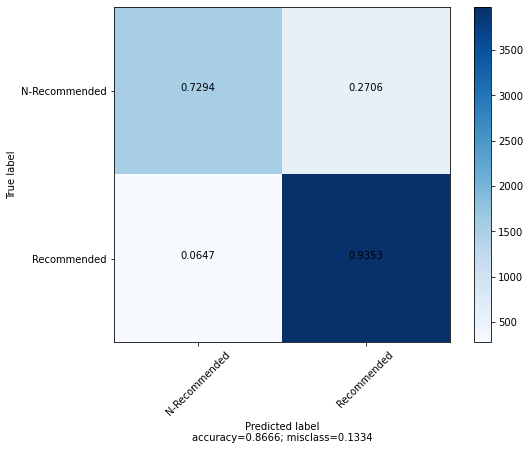

F1_score de: 92.8432%


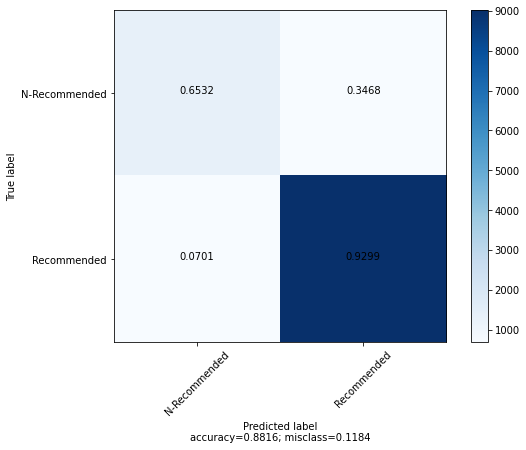



============================Unbalance Rate:2.499830451000339===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 2.499830451000339, 'f1_score_train': 0.8805046560528687, 'f1_score_val': 0.8788788788788788, 'f1_score_test': 0.9263228721103475}
F1_score de: 88.0505%


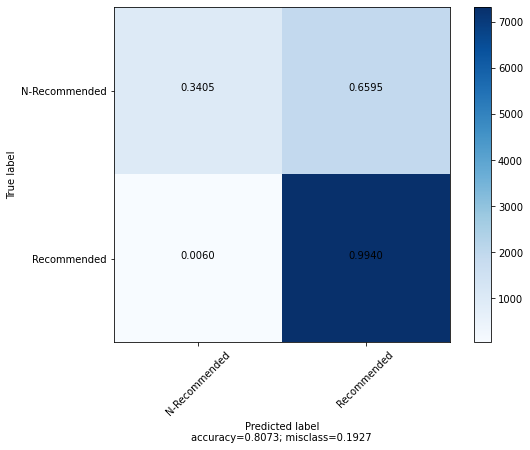

F1_score de: 87.8879%


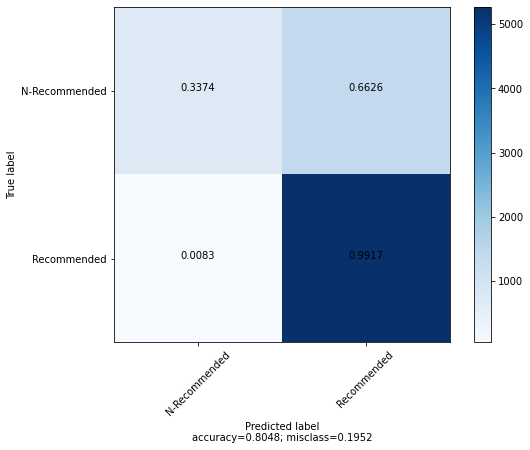

F1_score de: 92.6323%


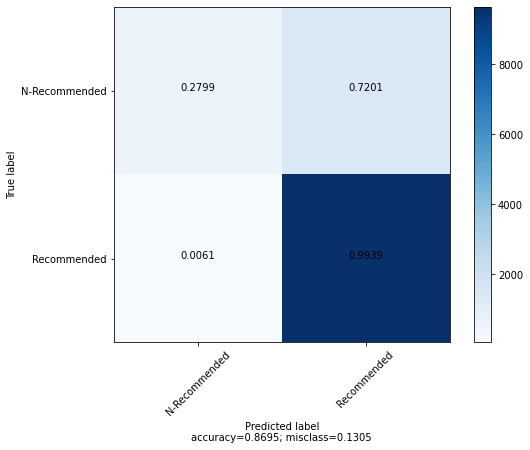



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 2.499830451000339, 'f1_score_train': 0.9782812709478482, 'f1_score_val': 0.9645617342130065, 'f1_score_test': 0.9472276514761856}
F1_score de: 97.8281%


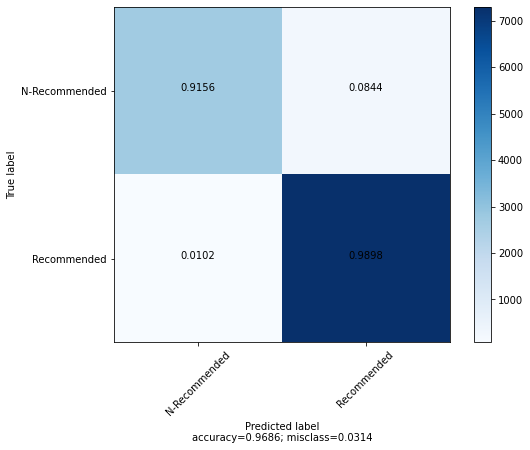

F1_score de: 96.4562%


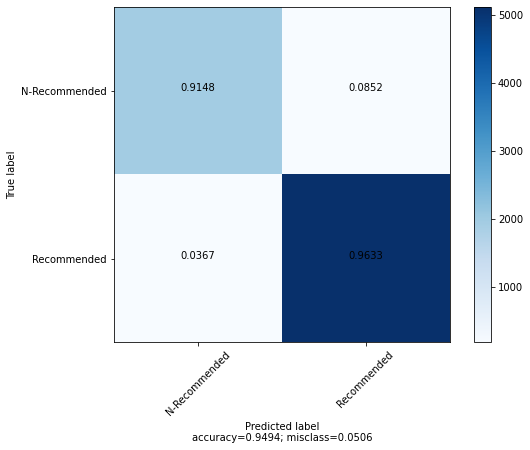

F1_score de: 94.7228%


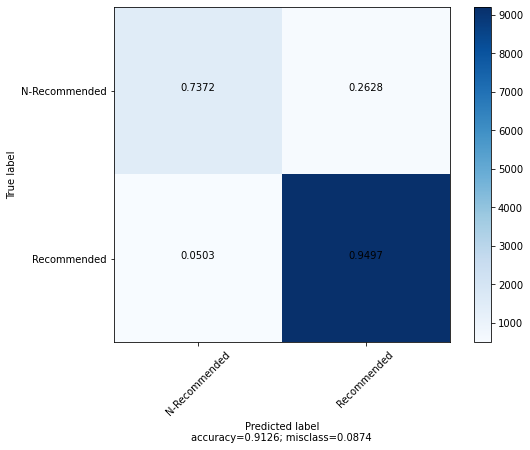



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

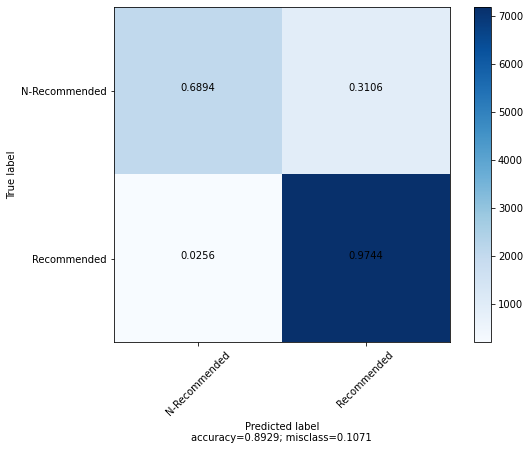

F1_score de: 91.721%


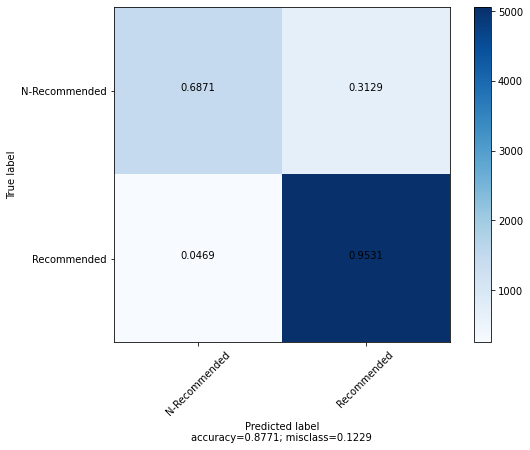

F1_score de: 93.2738%


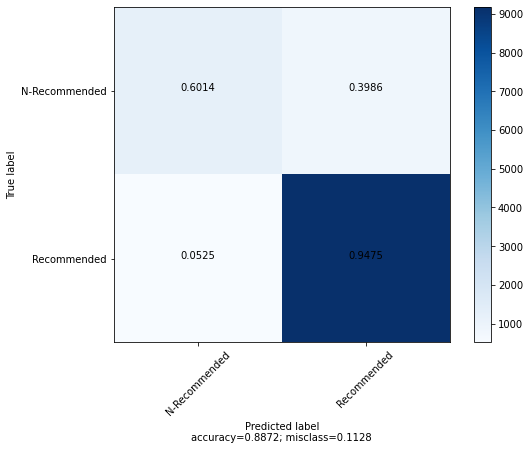



============================Unbalance Rate:3.0===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 3.0, 'f1_score_train': 0.8873805932629462, 'f1_score_val': 0.8876482903000698, 'f1_score_test': 0.9195719381688465}
F1_score de: 88.7381%


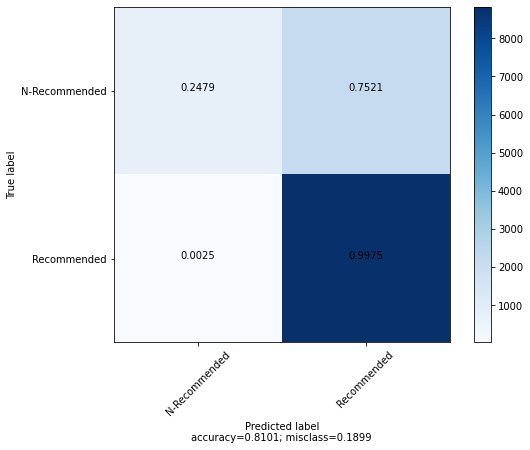

F1_score de: 88.7648%


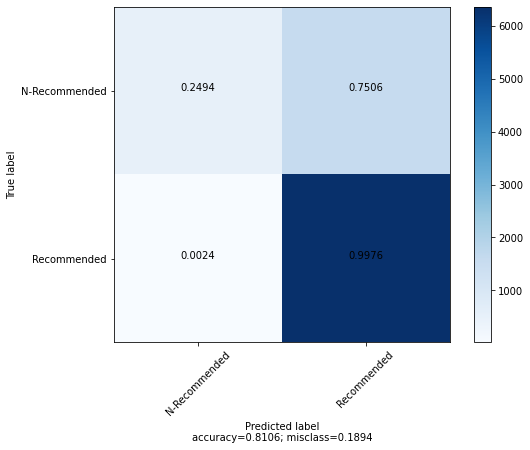

F1_score de: 91.9572%


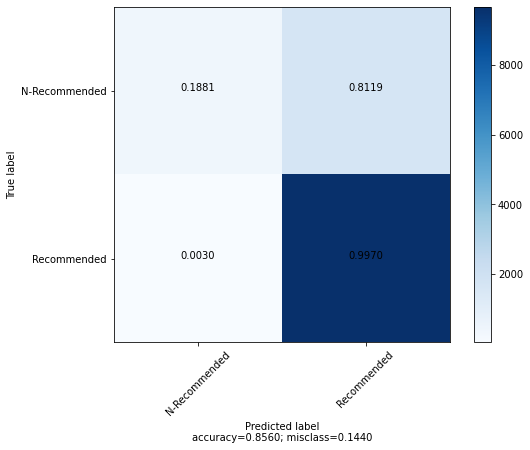



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 3.0, 'f1_score_train': 0.9801361455194734, 'f1_score_val': 0.9713661543262853, 'f1_score_test': 0.9499643330276165}
F1_score de: 98.0136%


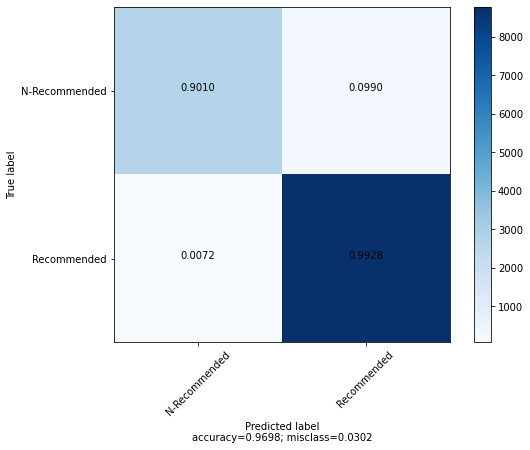

F1_score de: 97.1366%


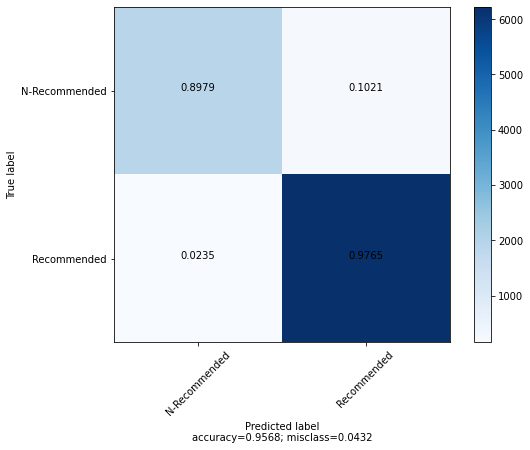

F1_score de: 94.9964%


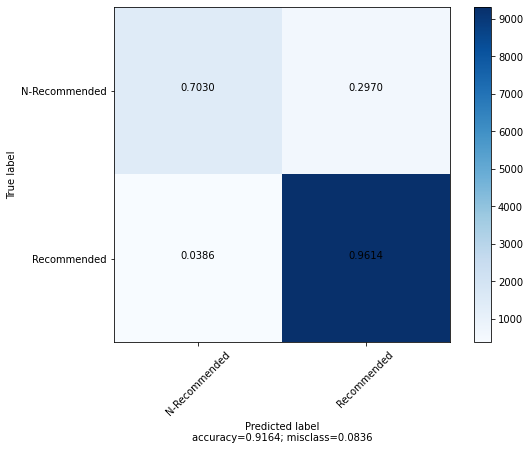



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

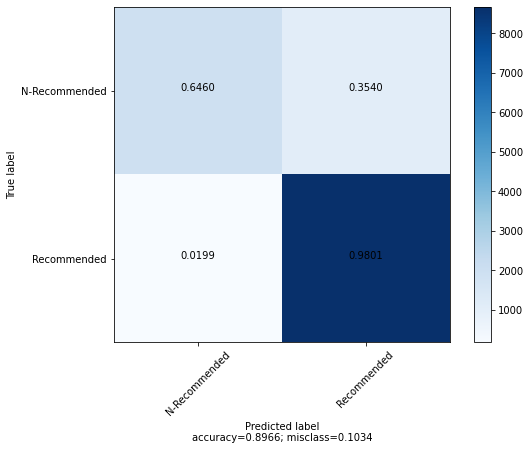

F1_score de: 92.797%


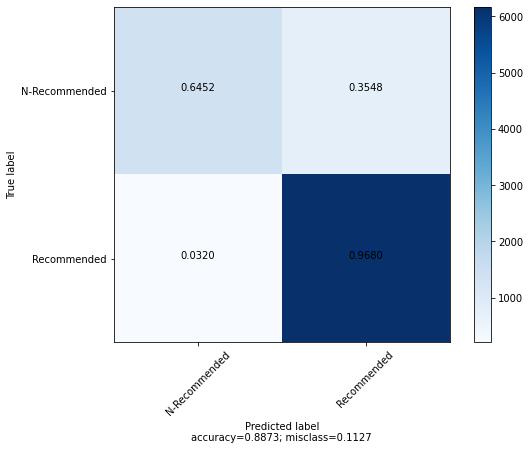

F1_score de: 93.328%


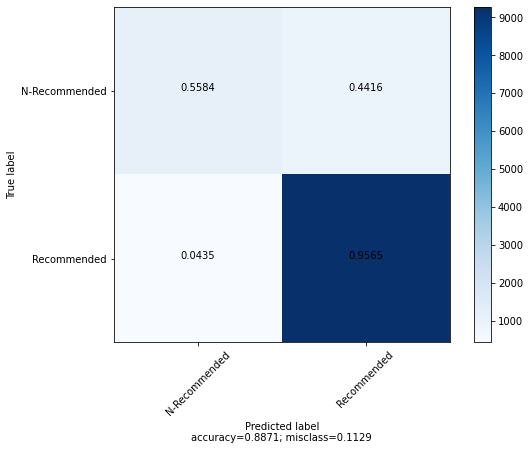



============================Unbalance Rate:3.499830451000339===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 3.499830451000339, 'f1_score_train': 0.8952397498262683, 'f1_score_val': 0.8951175406871609, 'f1_score_test': 0.9160045402951192}
F1_score de: 89.524%


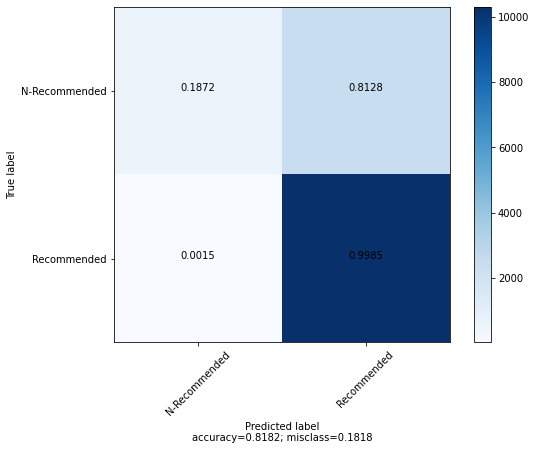

F1_score de: 89.5118%


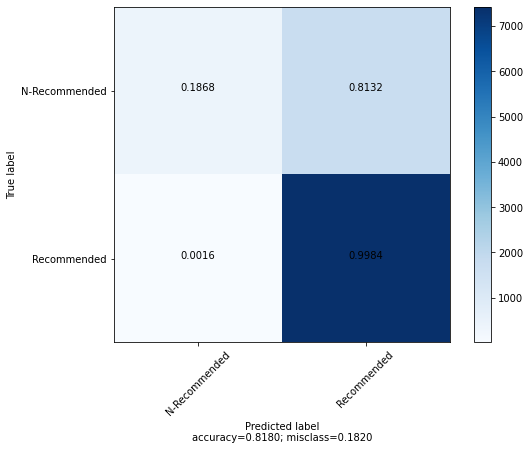

F1_score de: 91.6005%


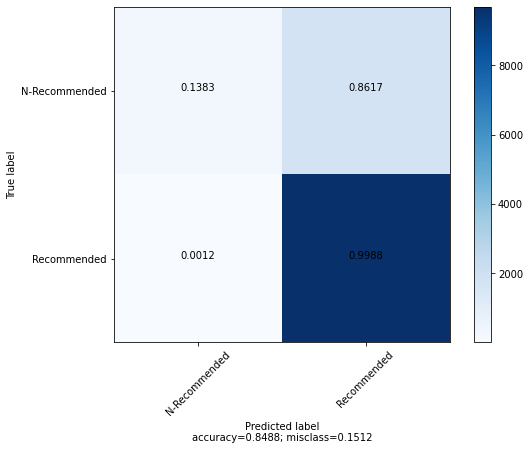



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 3.499830451000339, 'f1_score_train': 0.9812150470818796, 'f1_score_val': 0.9756032528996135, 'f1_score_test': 0.9518370647394754}
F1_score de: 98.1215%


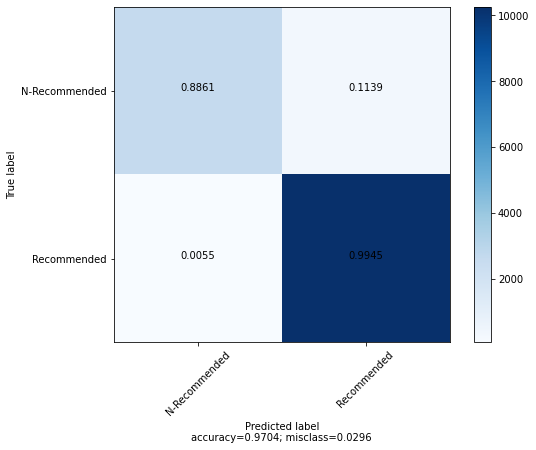

F1_score de: 97.5603%


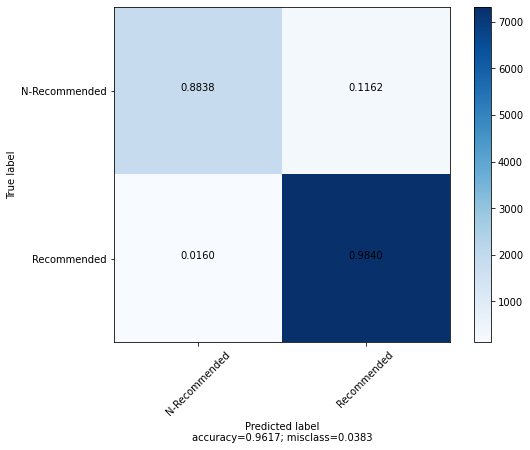

F1_score de: 95.1837%


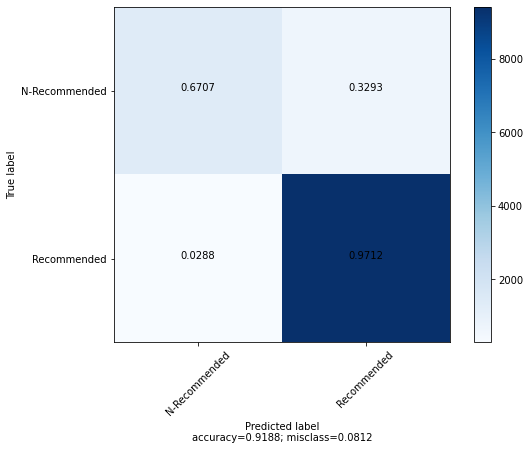



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

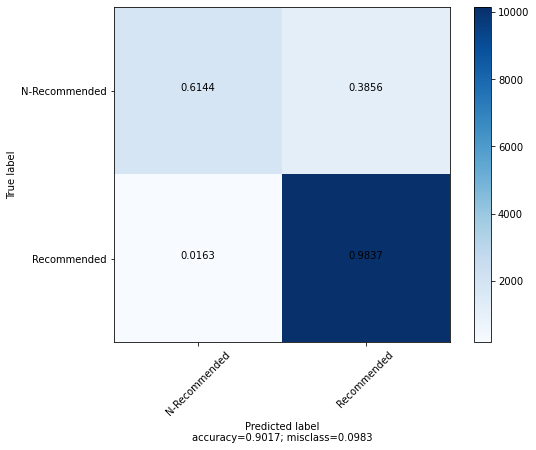

F1_score de: 93.5575%


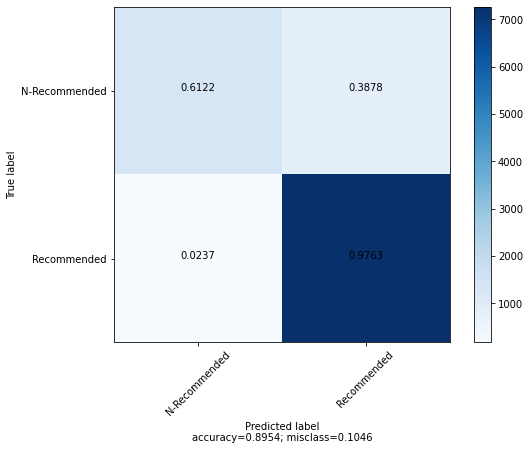

F1_score de: 93.4518%


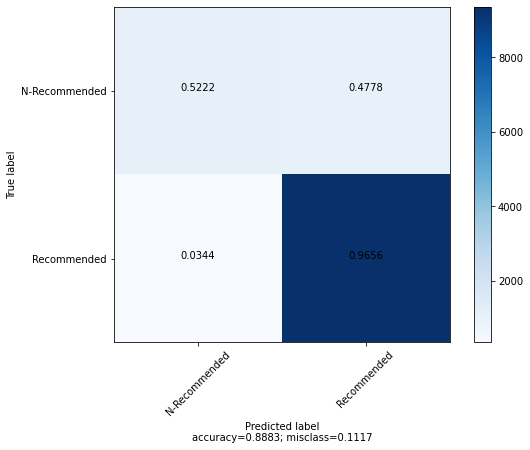



============================Unbalance Rate:3.999660902000678===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 3.999660902000678, 'f1_score_train': 0.9029885057471264, 'f1_score_val': 0.9024714323677916, 'f1_score_test': 0.9138760494292991}
F1_score de: 90.2989%


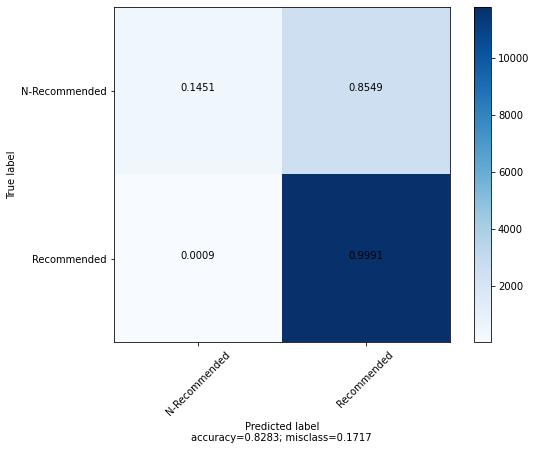

F1_score de: 90.2471%


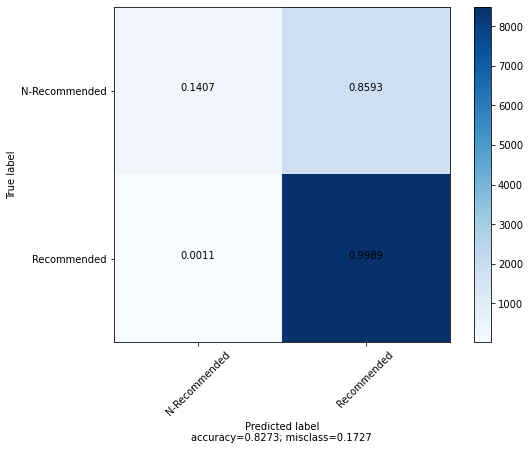

F1_score de: 91.3876%


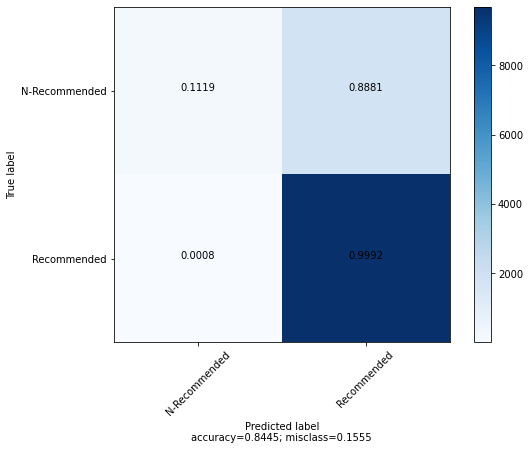



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 3.999660902000678, 'f1_score_train': 0.9816161109718392, 'f1_score_val': 0.9784933736340385, 'f1_score_test': 0.9524575334204443}
F1_score de: 98.1616%


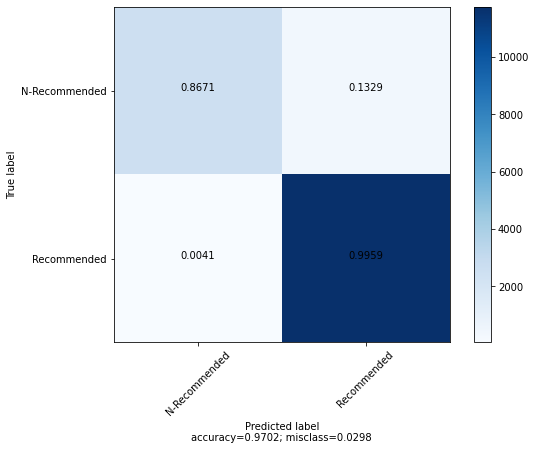

F1_score de: 97.8493%


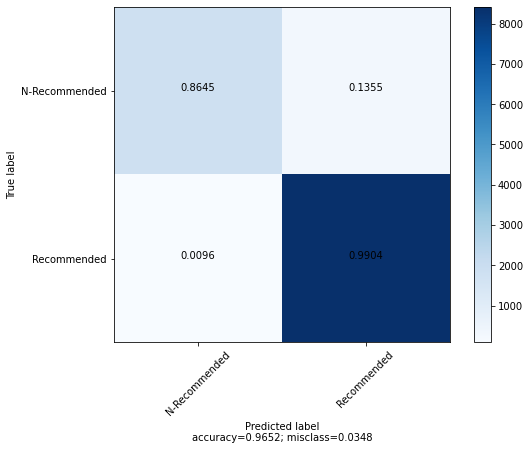

F1_score de: 95.2458%


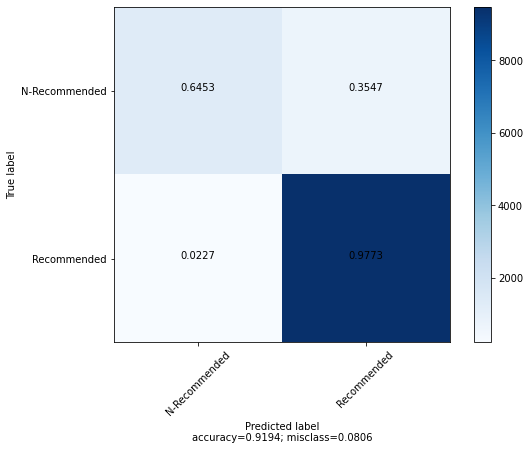



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

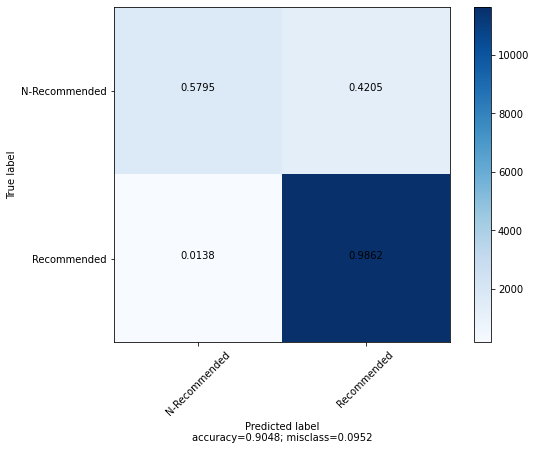

F1_score de: 94.0447%


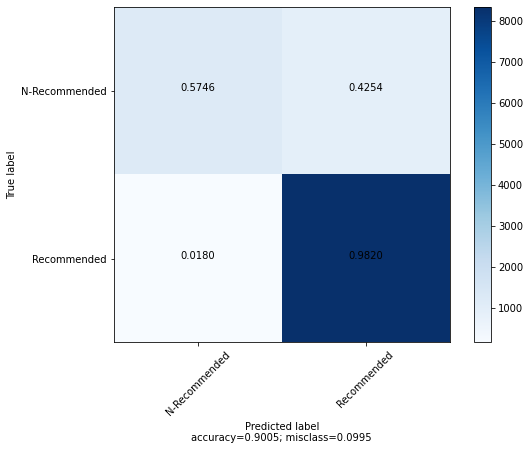

F1_score de: 93.5402%


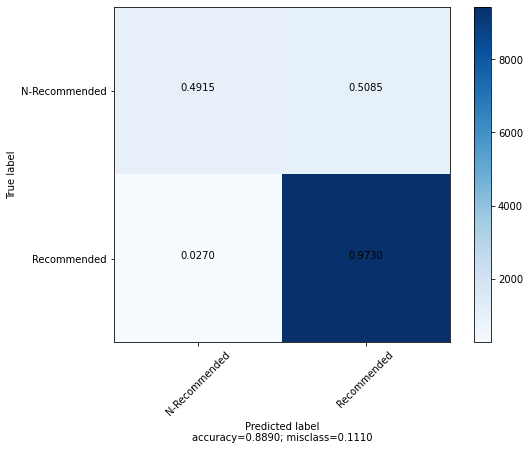



============================Unbalance Rate:4.4998304510003395===========================


{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 4.4998304510003395, 'f1_score_train': 0.9103827012184658, 'f1_score_val': 0.9100604675522544, 'f1_score_test': 0.9115364718054837}
F1_score de: 91.0383%


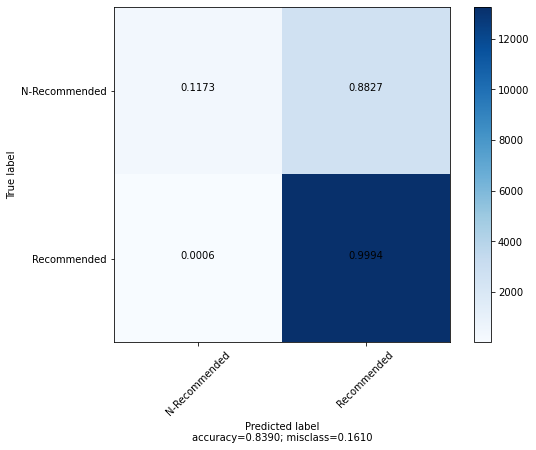

F1_score de: 91.006%


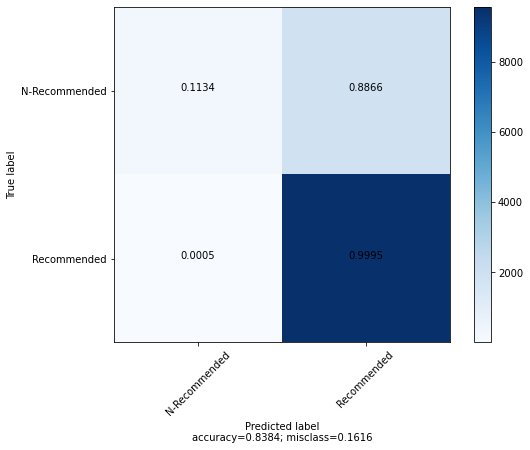

F1_score de: 91.1536%


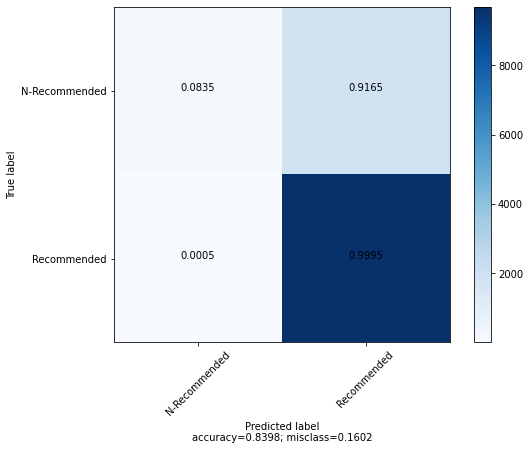



{'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'unbalance_rate': 4.4998304510003395, 'f1_score_train': 0.9818181818181818, 'f1_score_val': 0.980893031879281, 'f1_score_test': 0.9515427314097115}
F1_score de: 98.1818%


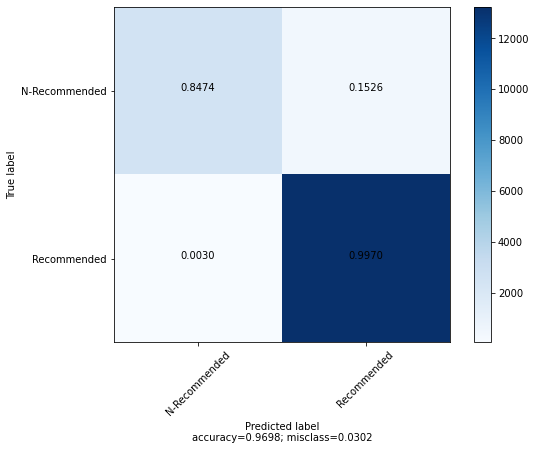

F1_score de: 98.0893%


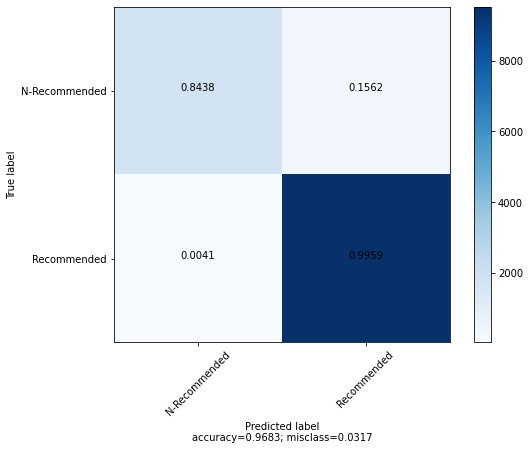

F1_score de: 95.1543%


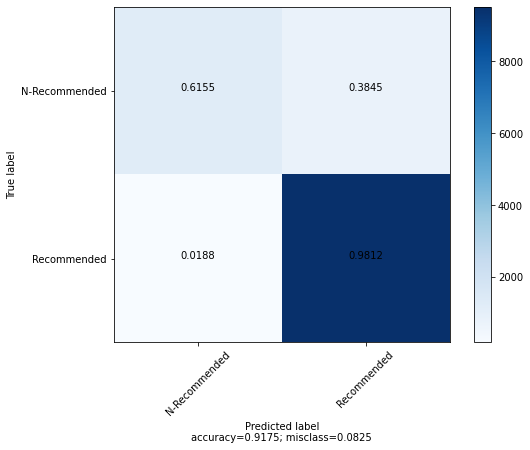



{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0), 'bow_model': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,

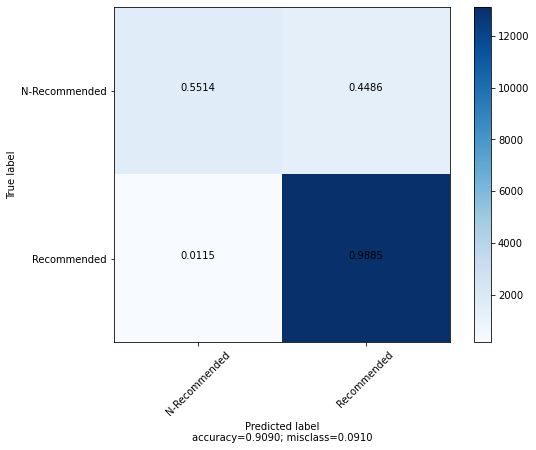

F1_score de: 94.5808%


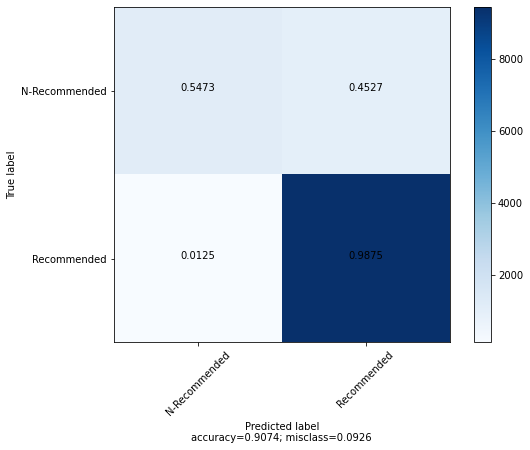

F1_score de: 93.472%


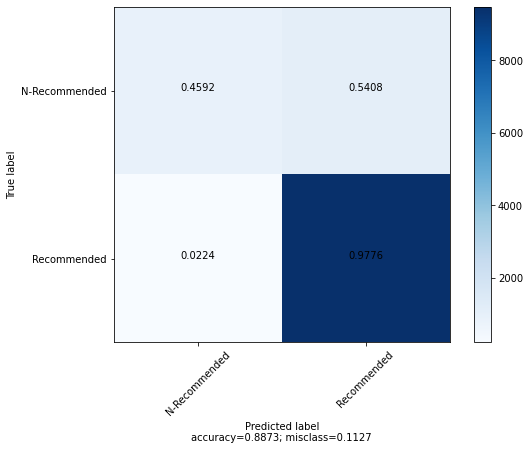

In [12]:
coefs = list(np.arange(1.0,5.0,0.5))
nb_dict = {}
svm_dict = {}
xgb_dict = {}
i = 0
for coef in coefs:
  train, test = train_test_split(df,test_size = 0.3, random_state = 7)
  val, test = train_test_split(df,test_size = 0.5, random_state = 7)

  train_aux, out = train_test_split(train[train['Recommended IND'] == 1],test_size = percent_out(qtd_1=train[train['Recommended IND'] == 1].shape[0],qtd_0=train[train['Recommended IND'] == 0].shape[0],coef=coef), random_state = 7)
  train = pd.concat([train_aux,train[train['Recommended IND'] == 0]], ignore_index=True) 
  train = train.sample(frac=1).reset_index(drop=True)
  del train_aux

  val_aux, out = train_test_split(val[val['Recommended IND'] == 1],test_size = percent_out(qtd_1=val[val['Recommended IND'] == 1].shape[0],qtd_0=val[val['Recommended IND'] == 0].shape[0],coef=coef), random_state = 7)
  val = pd.concat([val_aux,val[val['Recommended IND'] == 0]], ignore_index=True) 
  val = val.sample(frac=1).reset_index(drop=True)
  del val_aux

  unbalance_rate = train[train['Recommended IND'] == 1].shape[0]/train[train['Recommended IND'] == 0].shape[0]


  train_review = TextPreProcessing (df = train,text_column = 'Review Text', nlp_spacy = nlp)
  val_review = TextPreProcessing (df = val,text_column = 'Review Text', nlp_spacy = nlp)
  test_review = TextPreProcessing (df = test,text_column = 'Review Text', nlp_spacy = nlp)

  tfidf_vectorizer = TfidfVectorizer()

  bow_train = tfidf_vectorizer.fit_transform(train_review['Review Text'])
  bow_val = tfidf_vectorizer.transform(val_review['Review Text'])
  bow_test = tfidf_vectorizer.transform(test_review['Review Text'])

  print('============================Unbalance Rate:{}==========================='.format(unbalance_rate))
  print('\n')
  

  #Naive Bayes
  nb = MultinomialNB()
  nb.fit(bow_train,train['Recommended IND'])
  nb_dict[i] = {'model':nb,
                'bow_model': tfidf_vectorizer,
                'unbalance_rate': unbalance_rate,
                'f1_score_train': f1_score(train['Recommended IND'],nb.predict(bow_train)),
                'f1_score_val': f1_score(val['Recommended IND'],nb.predict(bow_val)),
                'f1_score_test':f1_score(test['Recommended IND'],nb.predict(bow_test))}

  print(nb_dict[i])
  show_confusion_matrix(train['Recommended IND'],val['Recommended IND'],test['Recommended IND'],nb.predict(bow_train),nb.predict(bow_val),nb.predict(bow_test))
  print('\n')


  #SVM
  svm_clf = svm.SVC()
  svm_clf.fit(bow_train,train['Recommended IND'])
  svm_dict[i] = {'model':svm_clf,
              'bow_model': tfidf_vectorizer,
              'unbalance_rate': unbalance_rate,
              'f1_score_train': f1_score(train['Recommended IND'],svm_clf.predict(bow_train)),
              'f1_score_val': f1_score(val['Recommended IND'],svm_clf.predict(bow_val)),
              'f1_score_test':f1_score(test['Recommended IND'],svm_clf.predict(bow_test))}

  print(svm_dict[i])
  show_confusion_matrix(train['Recommended IND'],val['Recommended IND'],test['Recommended IND'],svm_clf.predict(bow_train),svm_clf.predict(bow_val),svm_clf.predict(bow_test))
  print('\n')


  #XGB
  xgb_clf = xgb.XGBClassifier(learning_rate = 0.01,
                          max_depth = 10, 
                          n_estimators = 1000,
                          objective = 'binary:logistic',
                          verbosity = 0,
                          seed = 42,
                          reg_lambda = 8,
                          reg_alpha = 2,
                          gamma = 5,
                          subsample = 0.8,
                          tree_method = 'gpu_hist')
  xgb_clf.fit(bow_train,train['Recommended IND']) 
  xgb_dict[i] = {'model':xgb_clf,
            'bow_model': tfidf_vectorizer,
            'unbalance_rate': unbalance_rate,
            'f1_score_train': f1_score(train['Recommended IND'],xgb_clf.predict(bow_train)),
            'f1_score_val': f1_score(val['Recommended IND'],xgb_clf.predict(bow_val)),
            'f1_score_test':f1_score(test['Recommended IND'],xgb_clf.predict(bow_test))}

  print(xgb_dict[i])
  show_confusion_matrix(train['Recommended IND'],val['Recommended IND'],test['Recommended IND'],xgb_clf.predict(bow_train),xgb_clf.predict(bow_val),xgb_clf.predict(bow_test))
  print('\n')

  i +=1